In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

import pickle
import timeit
import time

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from matplotlib.widgets import Slider
from matplotlib.colors import LogNorm

# Object Volatility Model

In [2]:
feature_paths = [
    "./yj7full-result/exp1_prcc_buildats/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_itsttime/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_storesfg/roc-collect/feature.csv",
]
dff = pd.concat([pd.read_csv(feature_path) for feature_path in feature_paths], ignore_index=True)
dff

,Unnamed: 0,oid,global,type,type_global,type_pickler_dispatch,type_subclass_type,type_module,type_module_global,has_reduce_ex,has_reduce,size,len,len_dict,len_slots
0,0,140272584863536,False,str,False,False,False,builtins,True,True,True,57,8.0,NaN,NaN
1,1,140269739889648,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN
2,2,93855372871840,False,type,False,False,True,builtins,True,True,True,1072,NaN,17.0,NaN
3,3,140272583529712,False,str,False,False,False,builtins,True,True,True,59,10.0,NaN,NaN
4,4,140269839745648,False,str,False,False,False,builtins,True,True,True,54,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720346,538644,139749344735488,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN
720347,538645,139749341732080,False,bytes,False,False,False,builtins,True,True,True,49,16.0,NaN,NaN
720348,538646,139749344737280,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN
720349,538647,139749344737536,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN


In [3]:
change_paths = [
    "./yj7full-result/exp1_prcc_buildats/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_itsttime/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_rmlist/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_storesfg/roc-collect/change.csv",
]
dfc = pd.concat([pd.read_csv(change_path) for change_path in change_paths], ignore_index=True)
dfc

,Unnamed: 0,oid,nth,has_changed
0,0,140272584863536,0,True
1,1,140269739889648,0,True
2,2,93855372871840,0,True
3,3,140272583529712,0,True
4,4,140269839745648,0,True
...,...,...,...,...
11324822,8252316,139749344735488,1,False
11324823,8252317,139749341732080,1,False
11324824,8252318,139749344737280,1,False
11324825,8252319,139749344737536,1,False


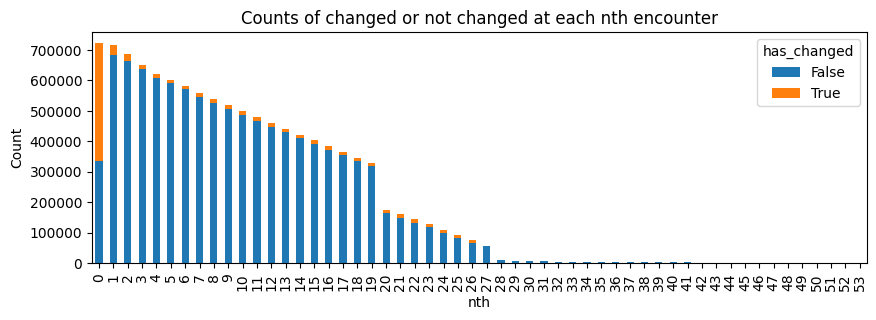

In [4]:
grouped = dfc.groupby(['nth', 'has_changed']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 3))
grouped.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('nth')
plt.ylabel('Count')
plt.title('Counts of changed or not changed at each nth encounter')
plt.legend(title='has_changed', labels=['False', 'True'])
plt.show()

In [5]:
dfc_agg = dfc[dfc['nth'] > 0].groupby('oid').agg({'has_changed': ['sum', 'count']})
dfc_agg.columns = ['num_changes', 'num_seen']
dfc_agg.reset_index(inplace=True)
dfc_agg

,oid,num_changes,num_seen
0,93855332171936,0,41
1,93855332172352,0,16
2,93855332173440,0,16
3,93855332208768,0,16
4,93855332221024,0,16
...,...,...,...
714915,140375195673968,0,9
714916,140375195938608,0,9
714917,140375196087920,0,9
714918,140375196099440,0,9


In [6]:
IMMUTABLE_TYPES = [
    'str',
    'bytes',
    'int',
    'float',
    'complex',
    'bool',
    'tuple',
    'frozenset',
    'NoneType',
    'type',
]

df = pd.merge(dff, dfc_agg, on='oid')
df['immutable_type'] = df['type'].isin(IMMUTABLE_TYPES)
df = df[df['immutable_type'] == False]
df

,Unnamed: 0,oid,global,type,type_global,type_pickler_dispatch,type_subclass_type,type_module,type_module_global,has_reduce_ex,has_reduce,size,len,len_dict,len_slots,num_changes,num_seen,immutable_type
1,1,140269739889648,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,0,41,False
6,6,140269739889552,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,0,41,False
8,8,140269739890464,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,0,41,False
10,10,140269739891568,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,0,41,False
12,12,140269739892192,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,0,41,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712728,538641,139749343776896,False,list,False,False,False,builtins,True,True,True,288,29.0,NaN,NaN,0,1,False
712729,538642,139749341726528,False,dict,False,False,False,builtins,True,True,True,232,2.0,NaN,NaN,0,1,False
712731,538644,139749344735488,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN,0,1,False
712733,538646,139749344737280,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN,0,1,False


In [7]:
X_df = df[[
    # 'oid',
    # 'global',  # low gain
    # 'type',
    # 'type_global',  # hard to extract
    # 'type_pickler_dispatch',  # low gain
    # 'type_subclass_type',  # low gain
    # 'type_module',
    # 'type_module_global',  # hard to extract
    # 'immutable_type',
    # 'has_reduce_ex',  # low gain
    # 'has_reduce',  # low gain
    'size',
    'len',
    'len_dict',
    # 'len_slots',  # low gain
    # 'num_changes',
    # 'num_seen'
]]
# X_df.loc[:,"obj_type"] = X_df["obj_type"].astype("category")
# ys = np.clip(df["num_changes"].astype("float").values - 1, a_min=0, a_max=float('inf')) / df["num_seen"].astype("float").values
ys = df["num_changes"].astype("float").values == 0
display(X_df)
display(ys)

,size,len,len_dict
1,48,NaN,2.0
6,48,NaN,2.0
8,48,NaN,2.0
10,48,NaN,2.0
12,48,NaN,2.0
...,...,...,...
712728,288,29.0,NaN
712729,232,2.0,NaN
712731,232,1.0,NaN
712733,232,1.0,NaN


array([ True,  True,  True, ...,  True,  True,  True])

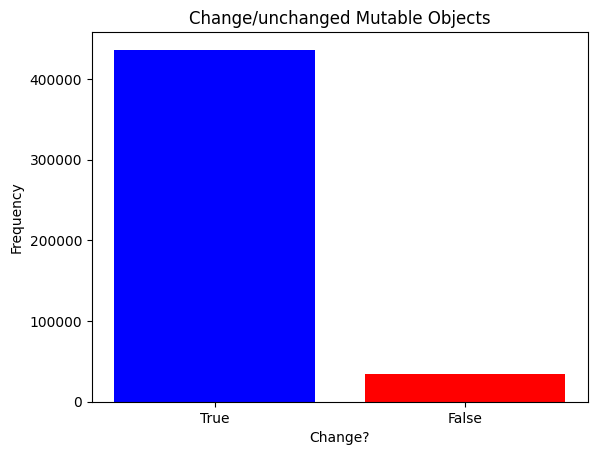

In [8]:
true_count = np.sum(ys)
false_count = len(ys) - true_count
x_labels = ['True', 'False']
y_values = [true_count, false_count]

plt.bar(x_labels, y_values, color=['blue', 'red'])
plt.xlabel('Change?')
plt.ylabel('Frequency')
plt.title('Change/unchanged Mutable Objects')
plt.show()

In [9]:
X_df.isna().sum()

size             0
len          23392
len_dict    446085
dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_df, ys, test_size=.2)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [11]:
params = {
    'objective': 'binary',          # Binary classification
    'metric': 'binary_error',      # Evaluation metric
    'boosting_type': 'gbdt',        # Gradient boosting decision tree
    'num_leaves': 4,
    'max_depth': 2,
}
num_round = 10
bst = lgb.train(params, lgb_train, num_round, valid_sets=lgb_test)
y_train_pred = bst.predict(X_train) > 0.5
y_test_pred = bst.predict(X_test) > 0.5
print("Train acc:", (y_train_pred == y_train).mean())
print("Test acc:", (y_test_pred == y_test).mean())

[LightGBM] [Info] Number of positive: 348896, number of negative: 27420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 376316, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.927136 -> initscore=2.543501
[LightGBM] [Info] Start training from score 2.543501
Train acc: 0.9518117752101957
Test acc: 0.9540072278911564


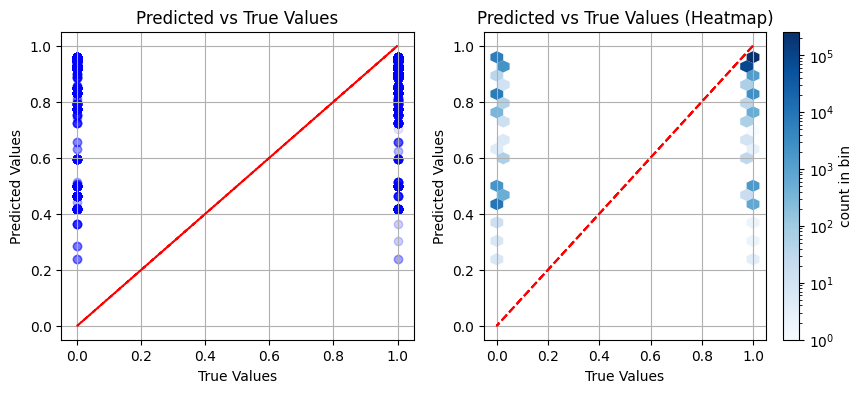

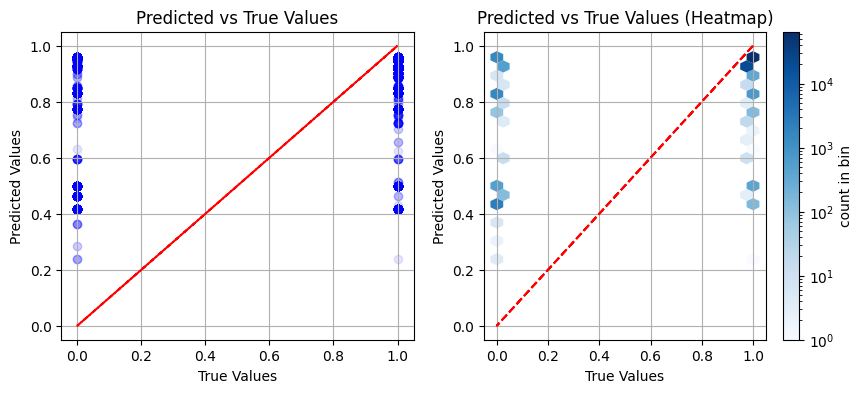

In [12]:
def plot_check(X_test, y_test, bst):
    y_test_pred = bst.predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    
    axs[0].scatter(y_test, y_test_pred, color='blue', alpha=0.1)
    axs[0].plot(y_test, y_test, color='red', linestyle='--')  # Plot y=x line for reference
    axs[0].set_title('Predicted vs True Values')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predicted Values')
    axs[0].grid(True)
    
    hb = axs[1].hexbin(y_test, y_test_pred, gridsize=20, cmap='Blues', edgecolors='none', norm=LogNorm())
    axs[1].plot(y_test, y_test, color='red', linestyle='--')  # Plot y=x line for reference
    plt.colorbar(hb, ax=axs[1], label='count in bin')
    axs[1].set_title('Predicted vs True Values (Heatmap)')
    axs[1].set_xlabel('True Values')
    axs[1].set_ylabel('Predicted Values')
    axs[1].grid(True)
    
    plt.show()

plot_check(X_train, y_train, bst)
plot_check(X_test, y_test, bst)

In [13]:
bst.save_model('models/roc_lgb.txt')

In [14]:
bst.predict([[1, 0, 0]])[0]

0.7676401724438179

In [15]:
isinstance(bst, lgb.Booster)

True

In [16]:
def strf_deltatime(time_s: float) -> str:
    if time_s == float("inf"):
        return "inf"
    if time_s >= 3600.0:
        return f"{time_s // 3600:.0f}:{(time_s % 3600) // 60:.0f}:{time_s % 60:.0f}"
    if time_s >= 60.0:
        return f"{time_s // 60:.0f}:{time_s % 60:.0f}"
    if time_s >= 1.0:
        return f"{time_s:.1f} sec"
    if time_s >= 1e-3:
        return f"{time_s*1e3:.1f} msec"
    return f"{time_s*1e6:.1f} usec"

ts = []
for _ in range(10000):
    xs = np.random.random((1, 3)) * 10
    # xs = [[xs[0, 0], xs[0, 1], xs[0, 2]]]
    t_start = time.time()
    y = bst.predict(xs, num_threads=1)[0]
    t_end = time.time()
    ts.append(t_end - t_start)
ts = np.array(ts)
print(f"{strf_deltatime(ts.mean())} +/- {strf_deltatime(ts.std())}")

21.6 usec +/- 10.7 usec
